# Part 3 -- Classification

The libraries that we are going to use:

In [1]:
import pandas as pd
import numpy as np
import csv
import random
import math
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import operator
from operator import itemgetter
from collections import Counter
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, auc
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

## Setting up

We are using a dictionary to map our Evaluation Metrics for each classifier in a way in which we can print the neatly in a "board" style when we are done.

In [2]:
EvaluationMetric = {
    'Statistic Measure':['Accuracy', 'Precision', 'Recall', 'F-Measure', 'AUC'], 
    'Naive Bayes':[] ,
    'Random Forest':[],
    'SVM':[],
    'KNN':[] }

In [3]:
testSet = {'ID':[], 'Predicted_Category':[]}
testSet_index = 0

In [4]:
mylist = {'Accuracy':[], 'Precision':[], 'Recall':[], 'F-Measure':[], 'AUC':[]}

We load our data and we define a list and a dictionary to help us with our following operations. Then we define our stopwords and our vectorizer, which is a *count vectorizer*. Following the project's specifiction suggestions, we are going to use the 'Title' field as a classification criterion.

In [5]:
# load our data
test_data = pd.read_csv('test_set.csv', sep='\t')
train_data = pd.read_csv('train_set.csv', sep='\t')

# a list of our categories (taken as facts)
categories = ['Politics','Football','Business','Technology','Film']

# we will use a number to represent each of our categories
category_dict = {'Politics':0, 'Football':1, 'Business':2, 'Technology':3, 'Film':4}

# for our text data, we use a count vectorizer
stopwords = set(STOPWORDS) | set(ENGLISH_STOP_WORDS)
# some additional stopwords based on our own observations
stopwords.add('said')
stopwords.add('say')
stopwords.add('says')
stopwords.add('set')

# our count vectorizer
count_vect = CountVectorizer(stop_words=stopwords)

# we will classify using the 'Title' as a criterion
category_criteria = 'Title'

In [6]:
train_data.head()

,RowNum,Id,Title,Content,Category
0,9560,9561,Sam Adams founder: Beer is more than just 'col...,"The craft beer boom, which and been attributed...",Business
1,10801,10802,Slump in oil prices could mean fall in investm...,The International Energy Agency has warned tha...,Business
2,6726,6727,British Gas owner Centrica warns of higher gas...,Senior executives at British have been accused...,Business
3,12365,12366,Ole Gunnar Solskjaer appointed manager of Card...,is confident he will have complete control of...,Football
4,11782,11783,Sunderland target loan signings of Kurt Zouma ...,Kurt Zouma and Jack Rodwell are on Sunderland’...,Football


## Data Preprocessing

In [7]:
# for training
X_train_counts = count_vect.fit_transform(train_data[category_criteria])
tfidf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_counts.shape)
print(X_train_counts.shape)

# for testing
X_test_counts = count_vect.transform(test_data[category_criteria])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_test_counts.shape)
print(X_test_tfidf.shape)

# we create a 'target' array where we will the category of each of our training data
target = []
for x in train_data['Category']:
    target.append(category_dict[x])

target = np.array(target)
print("target[] sample:")
print(target[:40])

(12266, 13712)
(12266, 13712)
(3067, 13712)
(3067, 13712)
target[] sample:
[2 2 2 1 1 2 0 1 2 4 2 4 4 4 2 4 0 2 0 0 1 3 0 2 4 1 0 4 2 3 1 0 0 2 1 3 2
 0 3 3]


Experimenting with Latent Semantic Indexing (LSI) for various number of components:

Latent Semantic Indexing (LSI) for various number of components: 
For  100  components:
Accuracy:
acc ==  0.823414315995
0.823414315995
For  200  components:
Accuracy:
acc ==  0.847219957606
0.847219957606
For  300  components:
Accuracy:
acc ==  0.861487037339
0.861487037339
For  400  components:
Accuracy:
acc ==  0.872574596445
0.872574596445
For  500  components:
Accuracy:
acc ==  0.877873797489
0.877873797489
For  600  components:
Accuracy:
acc ==  0.882113158324
0.882113158324


/home/marinos/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


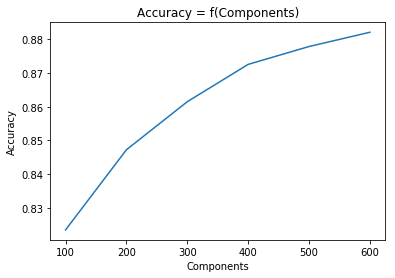

In [8]:
print("Latent Semantic Indexing (LSI) for various number of components: ")

accuracy = []
components = []
for i in range(6):
    components.append(i*100+100)
    print("For ", components[i], " components:")
    svd = TruncatedSVD(n_components=components[i])
    X_lsi = svd.fit_transform(X_train_tfidf)
    clfSVD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42).fit(X_lsi, target)
    X_test_lsi = svd.transform(X_train_counts)
    predictedSVD = clfSVD.predict(X_test_lsi)
    print("Accuracy:")
    acc = accuracy_score(target, predictedSVD)
    accuracy.append(acc)
    print("acc == ",acc)
    print(accuracy[i])

plt1.title('Accuracy = f(Components)')
plt1.plot(components, accuracy)
plt1.legend(loc = 'lower right')
plt1.ylabel('Accuracy')
plt1.xlabel('Components')
plt1.show()
cross_val_instance = 0


#### Our 10-fold cross validation function

In [9]:
# 10-FOLD CROSS VALIDATION FOR THE ARGUMENT'S CLASSIFIER
# global variable to keep track of how many times we have called the following function
cross_val_instance = 0

def cross_validate(clf):
    global cross_val_instance    # Needed to modify global copy of a global variable
    
    kf = KFold(n_splits=10)

    fold = 0
    for train_index, test_index in kf.split(train_data[category_criteria]):
        cross_val_instance += 1
        
        X_train_counts = count_vect.transform(train_data[category_criteria][train_index])
        X_test_counts = count_vect.transform(train_data[category_criteria][test_index].values.astype('U'))

        clf_cv = clf.fit(X_train_counts, target[train_index])
        yPred = clf_cv.predict(X_test_counts)
        fold += 1
        print ("Fold " + str(fold))
        
        accuracy = accuracy_score(target[test_index], yPred)
        mylist['Accuracy'].append(accuracy)
        print("Accuracy: ", accuracy)
        
        #A = auc(target[test_index], yPred, reorder=True)
        #mylist['AUC'].append(A)
        #print("AUC: ", A)
        
        p = metrics.precision_score(target[test_index], yPred, average='macro')
        mylist['Precision'].append(p)
        print("PRESICION: ", p)
        
        recall = metrics.recall_score(target[test_index], yPred, average='macro') 
        mylist['Recall'].append(recall)
        print("Recall: ", recall)
        f_1 = metrics.f1_score(target[test_index], yPred, average='micro') 
        mylist['F-Measure'].append(f_1)
        print("F-1: ", f_1)
        
        fpr, tpr, thresholds = metrics.roc_curve(target[test_index], yPred, pos_label=2)
        A = metrics.auc(fpr, tpr)
        print("AUC: ",A)
        mylist['AUC'].append(A)
        

        # construct ROC's plot
        plt2.subplot(6, 10, cross_val_instance)
        plt2.plot(fpr, tpr, 'b')
        plt2.plot([0,1], [0, 1],'r--')
        plt2.xlim([0,1])
        plt2.ylim([0, 1])

## Random Forest (RF) Classification

Classifying:

In [10]:
RANDOM_STATE = 123

rndf = RandomForestClassifier(warm_start=True, oob_score=True, max_features="sqrt", random_state=RANDOM_STATE)
rndf.set_params(n_estimators=30)
rndf.fit(X_train_tfidf, target)

predicted = rndf.predict(X_test_tfidf)

for x in range(10):
    print(test_data['Title'][x] + "---->" + categories[predicted[x]])

Syria airstrikes: Jeremy Corbyn gives Labour MPs free vote ---->Politics
Apple faces damages bill after jury finds iPhone and iPad chip violates processor patent ---->Technology
'I'm sitting next to a weirdo on the bus' and other true meanings of emoji ---->Technology
Black Friday 2015: UK retailers serve up alternative options ---->Business
A third of boardroom positions should be held by women, UK firms told ---->Business
Marks and Spencer customers hit by delays to online shopping orders ---->Business
Argos owner sees distorting effect of Black Friday on sales ---->Business
TalkTalk says hackers accessed fraction of data originally thought ---->Technology
Gameover Zeus returns: thieving malware rises a month after police action ---->Technology
TalkTalk boss says cybersecurity 'head and shoulders' above competitors ---->Business


In [11]:
i = 0
for x in predicted :
    testSet['ID'].append(train_data['Id'][i])
    testSet_index+=1
    i+=1
    testSet['Predicted_Category'].append(str(categories[x]))

Cross Validating:

In [12]:
# 10-FOLD CROSS VALIDATION FOR RF CLASSIFICATION
mylist = {'Accuracy':[], 'Precision':[], 'Recall':[], 'F-Measure':[], 'AUC':[]}
cross_validate(rndf)

/home/marinos/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Fold 1
Accuracy:  0.991035044825
PRESICION:  0.989384749981
Recall:  0.990774165485
F-1:  0.991035044825
AUC:  0.608916764577
Fold 2
Accuracy:  0.989405052975
PRESICION:  0.988332842019
Recall:  0.98783237197
F-1:  0.989405052975
AUC:  0.605693472927
Fold 3
Accuracy:  0.9902200489
PRESICION:  0.989042750174
Recall:  0.989098698168
F-1:  0.9902200489
AUC:  0.610897706836
Fold 4
Accuracy:  0.9934800326
PRESICION:  0.992187953556
Recall:  0.992900596293
F-1:  0.9934800326
AUC:  0.578441318449
Fold 5
Accuracy:  0.99185004075
PRESICION:  0.991220047171
Recall:  0.991245588691
F-1:  0.99185004075
AUC:  0.613842585609
Fold 6
Accuracy:  0.9869600652
PRESICION:  0.985666839531
Recall:  0.985452629565
F-1:  0.9869600652
AUC:  0.597410890514
Fold 7
Accuracy:  0.987765089723
PRESICION:  0.988093186277
Recall:  0.987187864585
F-1:  0.987765089723
AUC:  0.615101675588
Fold 8
Accuracy:  0.995921696574
PRESICION:  0.995205997415
Recall:  0.995662410167
F-1:  0.995921696574
AUC:  0.605170787277
Fold 9


Store RF's Evaluation Metrics in our dictionary:

In [13]:
EvaluationMetric['Random Forest']=[]
EvaluationMetric['Random Forest'].append(np.mean(mylist['Precision']))
EvaluationMetric['Random Forest'].append(np.mean(mylist['Recall']))
EvaluationMetric['Random Forest'].append(np.mean(mylist['F-Measure']))
EvaluationMetric['Random Forest'].append(np.mean(mylist['AUC']))
EvaluationMetric['Random Forest'].append(np.mean(mylist['Accuracy']))
EvaluationMetric

{'KNN': [],
 'Naive Bayes': [],
 'Random Forest': [0.9896212351486593,
  0.98964929609941843,
  0.99046142330462883,
  0.60494908523923507,
  0.99046142330462883],
 'SVM': [],
 'Statistic Measure': ['Accuracy', 'Precision', 'Recall', 'F-Measure', 'AUC']}

## Support Vector Machines Classification

### Part I -- with linear kernel and c=0.2

Classifying:

In [14]:
lnr = svm.SVC(C=0.2, kernel='linear')
lnr.fit(X_train_tfidf, target)

predicted = lnr.predict(X_test_tfidf)

print("SVM with linear kernel and c=0.2:")
for x in range(10):
    print(test_data['Title'][x] + "---->" + categories[predicted[x]])
    
print(predicted)

SVM with linear kernel and c=0.2:
Syria airstrikes: Jeremy Corbyn gives Labour MPs free vote ---->Politics
Apple faces damages bill after jury finds iPhone and iPad chip violates processor patent ---->Technology
'I'm sitting next to a weirdo on the bus' and other true meanings of emoji ---->Film
Black Friday 2015: UK retailers serve up alternative options ---->Business
A third of boardroom positions should be held by women, UK firms told ---->Business
Marks and Spencer customers hit by delays to online shopping orders ---->Business
Argos owner sees distorting effect of Black Friday on sales ---->Business
TalkTalk says hackers accessed fraction of data originally thought ---->Technology
Gameover Zeus returns: thieving malware rises a month after police action ---->Politics
TalkTalk boss says cybersecurity 'head and shoulders' above competitors ---->Business
[0 3 4 ..., 3 1 1]


In [15]:
i = 0
for x in predicted :
    testSet['ID'].append(train_data['Id'][i])
    testSet_index+=1
    i+=1
    testSet['Predicted_Category'].append(str(categories[x]))
print(len(testSet['ID']),len(testSet['Predicted_Category']))

6134 6134


Cross Validating:

In [16]:
# 10-FOLD CROSS VALIDATION FOR SVM CLASSIFICATION (I)
# with linear kernel and c=0.2
mylist = {'Accuracy':[], 'Precision':[], 'Recall':[], 'F-Measure':[], 'AUC':[]}
cross_validate(lnr)

Fold 1
Accuracy:  0.918500407498
PRESICION:  0.91757075151
Recall:  0.912208434671
F-1:  0.918500407498
AUC:  0.579489867226
Fold 2
Accuracy:  0.923390383048
PRESICION:  0.921925378451
Recall:  0.912066023875
F-1:  0.923390383048
AUC:  0.569844481019
Fold 3
Accuracy:  0.908720456398
PRESICION:  0.90273893386
Recall:  0.901835584143
F-1:  0.908720456398
AUC:  0.586424587487
Fold 4
Accuracy:  0.910350448248
PRESICION:  0.913037106346
Recall:  0.906168113688
F-1:  0.910350448248
AUC:  0.55192148137
Fold 5
Accuracy:  0.918500407498
PRESICION:  0.912397008362
Recall:  0.911178841417
F-1:  0.918500407498
AUC:  0.594595715794
Fold 6
Accuracy:  0.896495517522
PRESICION:  0.896217842102
Recall:  0.886978375802
F-1:  0.896495517522
AUC:  0.58331204768
Fold 7
Accuracy:  0.903752039152
PRESICION:  0.904609740542
Recall:  0.897569501622
F-1:  0.903752039152
AUC:  0.586655870894
Fold 8
Accuracy:  0.909461663948
PRESICION:  0.907808527014
Recall:  0.903905038073
F-1:  0.909461663948
AUC:  0.570005873

Store SVM's Evaluation Metrics in our dictionary:

In [17]:
EvaluationMetric['SVM']=[]
EvaluationMetric['SVM'].append(np.mean(mylist['Accuracy']))
EvaluationMetric['SVM'].append(np.mean(mylist['Precision']))
EvaluationMetric['SVM'].append(np.mean(mylist['Recall']))
EvaluationMetric['SVM'].append(np.mean(mylist['F-Measure']))
EvaluationMetric['SVM'].append(np.mean(mylist['AUC']))
EvaluationMetric

{'KNN': [],
 'Naive Bayes': [],
 'Random Forest': [0.9896212351486593,
  0.98964929609941843,
  0.99046142330462883,
  0.60494908523923507,
  0.99046142330462883],
 'SVM': [0.91211452221694844,
  0.91015357746674508,
  0.90401433137283504,
  0.91211452221694844,
  0.57831901248714579],
 'Statistic Measure': ['Accuracy', 'Precision', 'Recall', 'F-Measure', 'AUC']}

### Part II -- with rbf kernel, c=5000000.0 and gamma=100000

Classifying:

In [18]:
rbf = svm.SVC(C=5000000.0, kernel='rbf', gamma=100000)
rbf.fit(X_train_tfidf, target)

predicted = rbf.predict(X_test_tfidf)

print("SVM with rbf kernel, c=5000000.0 and gamma=100000:")
for x in range(10):
    print(test_data['Title'][x] + "---->" + categories[predicted[x]])

SVM with rbf kernel, c=5000000.0 and gamma=100000:
Syria airstrikes: Jeremy Corbyn gives Labour MPs free vote ---->Football
Apple faces damages bill after jury finds iPhone and iPad chip violates processor patent ---->Football
'I'm sitting next to a weirdo on the bus' and other true meanings of emoji ---->Football
Black Friday 2015: UK retailers serve up alternative options ---->Football
A third of boardroom positions should be held by women, UK firms told ---->Football
Marks and Spencer customers hit by delays to online shopping orders ---->Football
Argos owner sees distorting effect of Black Friday on sales ---->Football
TalkTalk says hackers accessed fraction of data originally thought ---->Football
Gameover Zeus returns: thieving malware rises a month after police action ---->Football
TalkTalk boss says cybersecurity 'head and shoulders' above competitors ---->Football


In [19]:
i = 0
for x in predicted :
    testSet['ID'].append(train_data['Id'][i])
    testSet_index+=1
    i+=1
    testSet['Predicted_Category'].append(str(categories[x]))
print(len(testSet['ID']),len(testSet['Predicted_Category']))

9201 9201


Cross Validating:

In [20]:
# 10-FOLD CROSS VALIDATION FOR SVM CLASSIFICATION (II)
# with rbf kernel, c=5000000.0 and gamma=100000
mylist = {'Accuracy':[], 'Precision':[], 'Recall':[], 'F-Measure':[], 'AUC':[]}
cross_validate(rbf)

Fold 1
Accuracy:  0.287693561532
PRESICION:  0.816177924217
Recall:  0.210933463303
F-1:  0.287693561532
AUC:  0.502292257009
Fold 2
Accuracy:  0.264058679707
PRESICION:  0.851112943116
Recall:  0.213320701982
F-1:  0.264058679707
AUC:  0.497054968835
Fold 3
Accuracy:  0.269763651182
PRESICION:  0.453594771242
Recall:  0.202545908479
F-1:  0.269763651182
AUC:  0.499490316004


/home/marinos/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 4
Accuracy:  0.237978810106
PRESICION:  0.247346938776
Recall:  0.201680672269
F-1:  0.237978810106
AUC:  0.498944033791
Fold 5
Accuracy:  0.259983700081
PRESICION:  0.251391162029
Recall:  0.20462962963
F-1:  0.259983700081
AUC:  0.497360084477
Fold 6
Accuracy:  0.257538712306
PRESICION:  0.450655737705
Recall:  0.207000028203
F-1:  0.257538712306
AUC:  0.496342737722
Fold 7
Accuracy:  0.261827079935
PRESICION:  0.850906095552
Recall:  0.211084844868
F-1:  0.261827079935
AUC:  0.5006651674
Fold 8
Accuracy:  0.245513866232
PRESICION:  0.448484848485
Recall:  0.204539232851
F-1:  0.245513866232
AUC:  0.499460671757
Fold 9
Accuracy:  0.26101141925
PRESICION:  0.651231527094
Recall:  0.206657639184
F-1:  0.26101141925
AUC:  0.50022751171
Fold 10
Accuracy:  0.26101141925
PRESICION:  0.451109285127
Recall:  0.207154692863
F-1:  0.26101141925
AUC:  0.498434237996


## Naive Bayes Classification 

### Part I -- with Multinomial Naive Bayes

Classifying:

In [21]:
mnb = MultinomialNB().fit(X_train_tfidf, target)

predicted = mnb.predict(X_test_tfidf)

print("Multinomial NB:")
for x in range(10):
    print(test_data['Title'][x] + "---->" + categories[predicted[x]])

Multinomial NB:
Syria airstrikes: Jeremy Corbyn gives Labour MPs free vote ---->Politics
Apple faces damages bill after jury finds iPhone and iPad chip violates processor patent ---->Technology
'I'm sitting next to a weirdo on the bus' and other true meanings of emoji ---->Politics
Black Friday 2015: UK retailers serve up alternative options ---->Business
A third of boardroom positions should be held by women, UK firms told ---->Business
Marks and Spencer customers hit by delays to online shopping orders ---->Business
Argos owner sees distorting effect of Black Friday on sales ---->Business
TalkTalk says hackers accessed fraction of data originally thought ---->Technology
Gameover Zeus returns: thieving malware rises a month after police action ---->Business
TalkTalk boss says cybersecurity 'head and shoulders' above competitors ---->Business


In [22]:
i = 0
for x in predicted :
    testSet['ID'].append(train_data['Id'][i])
    testSet_index+=1
    i+=1
    testSet['Predicted_Category'].append(str(categories[x]))
print(len(testSet['ID']),len(testSet['Predicted_Category']))

12268 12268


Cross Validating:

In [23]:
# 10-FOLD CROSS VALIDATION FOR NB CLASSIFICATION (I)
# with Multinomial Naive Bayes
mylist = {'Accuracy':[], 'Precision':[], 'Recall':[], 'F-Measure':[], 'AUC':[]}
cross_validate(mnb)

Fold 1
Accuracy:  0.925835370823
PRESICION:  0.923987190541
Recall:  0.917789562527
F-1:  0.925835370823
AUC:  0.592989993933
Fold 2
Accuracy:  0.926650366748
PRESICION:  0.929311760127
Recall:  0.915672904382
F-1:  0.926650366748
AUC:  0.59027682531
Fold 3
Accuracy:  0.911980440098
PRESICION:  0.906239387259
Recall:  0.903324389757
F-1:  0.911980440098
AUC:  0.609163538119
Fold 4
Accuracy:  0.913610431948
PRESICION:  0.913924365586
Recall:  0.911180868099
F-1:  0.913610431948
AUC:  0.559647005582
Fold 5
Accuracy:  0.920130399348
PRESICION:  0.918808367992
Recall:  0.914964289279
F-1:  0.920130399348
AUC:  0.613799215568
Fold 6
Accuracy:  0.902200488998
PRESICION:  0.899175374797
Recall:  0.89072561377
F-1:  0.902200488998
AUC:  0.601993111189
Fold 7
Accuracy:  0.899673735726
PRESICION:  0.896644827667
Recall:  0.889089629947
F-1:  0.899673735726
AUC:  0.597154033765
Fold 8
Accuracy:  0.924959216966
PRESICION:  0.92386627992
Recall:  0.91946875373
F-1:  0.924959216966
AUC:  0.585895587

Store NB's Evaluation Metrics in our dictionary:

In [24]:
EvaluationMetric['Naive Bayes']=[]
EvaluationMetric['Naive Bayes'].append(np.mean(mylist['Accuracy']))
EvaluationMetric['Naive Bayes'].append(np.mean(mylist['Precision']))
EvaluationMetric['Naive Bayes'].append(np.mean(mylist['Recall']))
EvaluationMetric['Naive Bayes'].append(np.mean(mylist['F-Measure']))
EvaluationMetric['Naive Bayes'].append(np.mean(mylist['AUC']))
EvaluationMetric

{'KNN': [],
 'Naive Bayes': [0.91570143495122669,
  0.91339916993948089,
  0.90713833367009133,
  0.91570143495122669,
  0.59352342417638937],
 'Random Forest': [0.9896212351486593,
  0.98964929609941843,
  0.99046142330462883,
  0.60494908523923507,
  0.99046142330462883],
 'SVM': [0.91211452221694844,
  0.91015357746674508,
  0.90401433137283504,
  0.91211452221694844,
  0.57831901248714579],
 'Statistic Measure': ['Accuracy', 'Precision', 'Recall', 'F-Measure', 'AUC']}

### Part II -- with Bernoulli Naive Bayes

Classifying:

In [25]:
bnb = BernoulliNB().fit(X_train_tfidf, target)

predicted = bnb.predict(X_test_tfidf)

print("Bernoulli NB:")
for x in range(10):
    print(test_data['Title'][x] + "---->" + categories[predicted[x]])

Bernoulli NB:
Syria airstrikes: Jeremy Corbyn gives Labour MPs free vote ---->Politics
Apple faces damages bill after jury finds iPhone and iPad chip violates processor patent ---->Technology
'I'm sitting next to a weirdo on the bus' and other true meanings of emoji ---->Film
Black Friday 2015: UK retailers serve up alternative options ---->Business
A third of boardroom positions should be held by women, UK firms told ---->Business
Marks and Spencer customers hit by delays to online shopping orders ---->Business
Argos owner sees distorting effect of Black Friday on sales ---->Business
TalkTalk says hackers accessed fraction of data originally thought ---->Technology
Gameover Zeus returns: thieving malware rises a month after police action ---->Business
TalkTalk boss says cybersecurity 'head and shoulders' above competitors ---->Business


In [26]:
for x in predicted :
    testSet['ID'].append(testSet_index)
    testSet_index+=1
    testSet['Predicted_Category'].append(str(categories[x]))

print(len(testSet['ID']),len(testSet['Predicted_Category']))

15335 15335


Cross Validating:

In [27]:
# 10-FOLD CROSS VALIDATION FOR NB CLASSIFICATION (II)
# with Bernoulli Naive Bayes
cross_validate(bnb)

Fold 1
Accuracy:  0.903015484923
PRESICION:  0.914595832371
Recall:  0.877694811439
F-1:  0.903015484923
AUC:  0.612147810261
Fold 2
Accuracy:  0.898125509372
PRESICION:  0.907901236104
Recall:  0.869286032524
F-1:  0.898125509372
AUC:  0.618896584831
Fold 3
Accuracy:  0.883455582722
PRESICION:  0.889049697639
Recall:  0.854443218152
F-1:  0.883455582722
AUC:  0.633932937189
Fold 4
Accuracy:  0.876935615322
PRESICION:  0.890041322743
Recall:  0.852510308066
F-1:  0.876935615322
AUC:  0.593717001056
Fold 5
Accuracy:  0.899755501222
PRESICION:  0.909187880073
Recall:  0.877218402294
F-1:  0.899755501222
AUC:  0.633651380299
Fold 6
Accuracy:  0.872045639772
PRESICION:  0.885517187364
Recall:  0.843484833596
F-1:  0.872045639772
AUC:  0.619931111885
Fold 7
Accuracy:  0.880913539967
PRESICION:  0.891157594469
Recall:  0.853978371785
F-1:  0.880913539967
AUC:  0.621909743119
Fold 8
Accuracy:  0.89722675367
PRESICION:  0.907742229699
Recall:  0.874801531248
F-1:  0.89722675367
AUC:  0.6088784

## K-Nearest Neighbor Classification

#### Our assistant-funtions for the K-Nearest Neighbor Classification

In [28]:
train_array = svd.fit_transform(X_train_tfidf)
test_array = svd.fit_transform(X_test_tfidf)

In [29]:
# given two data points, calculate the euclidean distance between them
def get_distance(data1, data2):
    points = zip(data1, data2)
    diffs_squared_distance = [pow(a - b, 2) for (a, b) in points]
    return math.sqrt(sum(diffs_squared_distance))

# a function that returns sorted distances between a test case and all training cases
def get_neighbours(training_set, test_instance, k):
    distances = [_get_tuple_distance(training_instance, test_instance) for training_instance in training_set]
    # index 1 is the calculated distance between training_instance and test_instance
    sorted_distances = sorted(distances, key=itemgetter(1))
    # extract only training instances
    sorted_training_instances = [tuple[0] for tuple in sorted_distances]
    # select first k elements
    return sorted_training_instances[:k]
 
def _get_tuple_distance(training_instance, test_instance):
    return (training_instance, get_distance(test_instance, training_instance))

# given an array of nearest neighbours for a test case, tally up their classes to vote on test case class
def get_majority_vote(neighbours):
    # index 1 is the class
    classes = [neighbour[1] for neighbour in neighbours]
    count = Counter(classes)
    return count.most_common()[0][0]

#### Our K-Nearest Neighbor Classification function

In [30]:
# generate predictions
def KNN(train_array,test_array): #synarthsh pou epistrefeei thn lista me ta predictions
    predictions = []
    # let's arbitrarily set k equal to 3
    k = 3

    # for each instance in the test set, get nearest neighbours and majority vote on predicted class
    for x in range(len(test_array)):#mono ta prwta 5
        #print('Classifying test instance number ' + str(x) + ":")
        neighbours = get_neighbours(training_set=train_array, test_instance=test_array[x], k=2)
        majority_vote = get_majority_vote(neighbours)
        predictions.append(majority_vote)
        #print ('Predicted label=' + str(majority_vote) + ', Actual label=' + str(test_array[x][1]))
    for y in range(len(predictions)):
        predictions[y] = math.ceil(predictions[y])
    #print(predictions)
    return predictions

In [31]:
print(cross_val_instance)

50


#### Our K-Nearest Neighbor Cross Validation function

In [32]:
# 10-FOLD CROSS VALIDATION FOR THE ARGUMENT'S CLASSIFIER
# global variable to keep track of how many times we have called the following function
mylist = {'Accuracy':[], 'Precision':[], 'Recall':[], 'F-Measure':[], 'AUC':[]}
global cross_val_instance    # Needed to modify global copy of a global variable
    
kf = KFold(n_splits=10)

fold = 0
for train_index, test_index in kf.split(train_data[category_criteria]):
    cross_val_instance += 1

    X_train_counts = count_vect.transform(train_data[category_criteria][train_index])
    X_test_counts = count_vect.transform(train_data[category_criteria][test_index].values.astype('U'))

    #clf_cv = clf.fit(X_train_counts, target[train_index])
    #yPred = clf_cv.predict(X_test_counts)
    X_train_counts = svd.fit_transform(X_train_counts)
    X_test_counts = svd.fit_transform(X_test_counts)
    X_test_counts = X_test_counts[0:30]    # we take only the first 5
    test_index = test_index[0:30]
    yPred = KNN( X_train_counts ,  X_test_counts )
    fold += 1
    print ("Fold " + str(fold))

    accuracy = accuracy_score(target[test_index], yPred)
    mylist['Accuracy'].append(accuracy)
    print("Accuracy: ", accuracy)

#     A = auc(target[test_index], yPred, reorder=True)
#     mylist['AUC'].append(A)
#     print("AUC: ", A)

    p = metrics.precision_score(target[test_index], yPred, average='macro')
    mylist['Precision'].append(p)
    print("PRESICION: ", p)

    recall = metrics.recall_score(target[test_index], yPred, average='macro') 
    mylist['Recall'].append(recall)
    print("Recall: ", recall)
    f_1 = metrics.f1_score(target[test_index], yPred, average='micro') 
    mylist['F-Measure'].append(f_1)
    print("F-1: ", f_1)

    fpr, tpr, thresholds = metrics.roc_curve(target[test_index], yPred, pos_label=2)
    A = metrics.auc(fpr, tpr)
    print("AUC: ", A)
    mylist['AUC'].append(A)
        
    # construct ROC's plot
    plt2.subplot(6, 10, cross_val_instance)
    plt2.plot(fpr, tpr, 'b')

Fold 1
Accuracy:  0.133333333333
PRESICION:  0.0275862068966
Recall:  0.16
F-1:  0.133333333333
AUC:  0.525


/home/marinos/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 2
Accuracy:  0.0666666666667
PRESICION:  0.0153846153846
Recall:  0.08
F-1:  0.0666666666667
AUC:  0.5
Fold 3
Accuracy:  0.133333333333
PRESICION:  0.0685714285714
Recall:  0.0945454545455
F-1:  0.133333333333
AUC:  0.520833333333
Fold 4
Accuracy:  0.133333333333
PRESICION:  0.0285714285714
Recall:  0.133333333333
F-1:  0.133333333333
AUC:  0.5
Fold 5
Accuracy:  0.3
PRESICION:  0.160256410256
Recall:  0.253472222222
F-1:  0.3
AUC:  0.536931818182
Fold 6
Accuracy:  0.1
PRESICION:  0.024
Recall:  0.075
F-1:  0.1
AUC:  0.521739130435
Fold 7
Accuracy:  0.233333333333
PRESICION:  0.0538461538462
Recall:  0.127272727273
F-1:  0.233333333333
AUC:  0.54
Fold 8
Accuracy:  0.133333333333
PRESICION:  0.0384615384615
Recall:  0.125
F-1:  0.133333333333
AUC:  0.590909090909
Fold 9
Accuracy:  0.233333333333
PRESICION:  0.048275862069
Recall:  0.175
F-1:  0.233333333333
AUC:  0.48
Fold 10
Accuracy:  0.2
PRESICION:  0.0444444444444
Recall:  0.133333333333
F-1:  0.2
AUC:  0.52


Store KNN's Evaluation Metrics in our dictionary:

In [33]:
EvaluationMetric['KNN'] =[]
EvaluationMetric['KNN'].append(np.mean(mylist['Accuracy']))
EvaluationMetric['KNN'].append(np.mean(mylist['Precision']))
EvaluationMetric['KNN'].append(np.mean(mylist['Recall']))
EvaluationMetric['KNN'].append(np.mean(mylist['F-Measure']))
EvaluationMetric['KNN'].append(np.mean(mylist['AUC']))
EvaluationMetric

{'KNN': [0.16666666666666669,
  0.05093980885015368,
  0.13569570707070705,
  0.16666666666666669,
  0.52354133728590246],
 'Naive Bayes': [0.91570143495122669,
  0.91339916993948089,
  0.90713833367009133,
  0.91570143495122669,
  0.59352342417638937],
 'Random Forest': [0.9896212351486593,
  0.98964929609941843,
  0.99046142330462883,
  0.60494908523923507,
  0.99046142330462883],
 'SVM': [0.91211452221694844,
  0.91015357746674508,
  0.90401433137283504,
  0.91211452221694844,
  0.57831901248714579],
 'Statistic Measure': ['Accuracy', 'Precision', 'Recall', 'F-Measure', 'AUC']}

## Presenting our Results

We present our 10-fold Cross Validation's Evaluation Metrics:

In [34]:
# creating the dataframe
EvaluationMetric_10fold = pd.DataFrame(data=EvaluationMetric)
EvaluationMetric_10fold

,KNN,Naive Bayes,Random Forest,SVM,Statistic Measure
0,0.166667,0.915701,0.989621,0.912115,Accuracy
1,0.050940,0.913399,0.989649,0.910154,Precision
2,0.135696,0.907138,0.990461,0.904014,Recall
3,0.166667,0.915701,0.604949,0.912115,F-Measure
4,0.523541,0.593523,0.990461,0.578319,AUC


In [35]:
# making sure that the dataframe will be printed with the columns in the correct order
EvaluationMetric_10fold = EvaluationMetric_10fold.ix[::, ['Statistic Measure', 'Naive Bayes', 'Random Forest', 'SVM', 'KNN']]
EvaluationMetric_10fold

,Statistic Measure,Naive Bayes,Random Forest,SVM,KNN
0,Accuracy,0.915701,0.989621,0.912115,0.166667
1,Precision,0.913399,0.989649,0.910154,0.050940
2,Recall,0.907138,0.990461,0.904014,0.135696
3,F-Measure,0.915701,0.604949,0.912115,0.166667
4,AUC,0.593523,0.990461,0.578319,0.523541


In [36]:
# creating the evaluation metrics' csv file
EvaluationMetric_10fold.to_csv(path_or_buf='EvaluationMetric_10fold.csv', sep='\t', index=False)

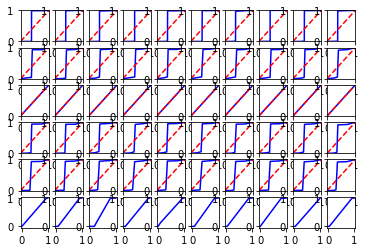

In [37]:
# save as .png and then show plot
plt2.savefig("roc_10fold.png")
plt2.show()

In [38]:
print(len(testSet['ID']),len(testSet['Predicted_Category']))

15335 15335


In [39]:
# printing our test set's data frame
testSetpd = pd.DataFrame(data=testSet)
testSetpd

,ID,Predicted_Category
0,9561,Politics
1,10802,Technology
2,6727,Technology
3,12366,Business
4,11783,Business
5,14177,Business
6,308,Business
7,13636,Technology
8,1042,Technology
9,1227,Business


In [40]:
testSetcsv = testSetpd.ix[::, ['ID', 'Predicted_Category']]

In [41]:
testSetcsv.to_csv(path_or_buf='testSet_categories.csv', sep = '\t')